# Incremental Local Outlier factor

##### Created by: Pietro TANURE ONNIS
##### Final project for the Online Machine Learning course at Telecom Paris 2023

The Incremental Local Outlier Factor (ILOF) is an online version of the Local Outlier Factor (LOF) used to identify outliers based on density of local neighbors.

We consider: 

    - NewPoints: new points; 
    - kNN(p): the neighboors of p (the k closest points to p)
    - RkNN(p): the rev-neighboors of p (points that have p as one of their neighboors)
    - Set_upd_lrd: Set of points that need to update the local reachability distance
    - Set_upd_lof: Set of points that need to update the local outlier factor

The algorithm here implemented based on the original one in the paper is:

    1) Insert NewPoints and calculate its distance to existing points
    2) Update the neighboors and reverse-neighboors of all the points
    3) Define sets of affected points that required update
    4) Calculate the reachability-distance from new point to neighboors (NewPoints -> kNN(NewPoints)) and from rev-neighboors to new point (RkNN(NewPoints) -> NewPoints)
    5) Update the reachability-distance for affected points: RkNN(RkNN(NewPoints)) -> RkNN(NewPoints)
    6) Update local reachability distance of affected points: lrd(Set_upd_lrd)
    7) Update local outlier factor: lof(Set_upd_lof)

Reference: Pokrajac, David & Lazarevic, Aleksandar & Latecki, Longin Jan. (2007). Incremental Local Outlier Detection for Data Streams. Proceedings of the 2007 IEEE Symposium on Computational Intelligence and Data Mining, CIDM 2007. 504-515. 10.1109/CIDM.2007.368917. 

![Screenshot from 2023-06-08 10-01-42.png](<attachment:Screenshot from 2023-06-08 10-01-42.png>)
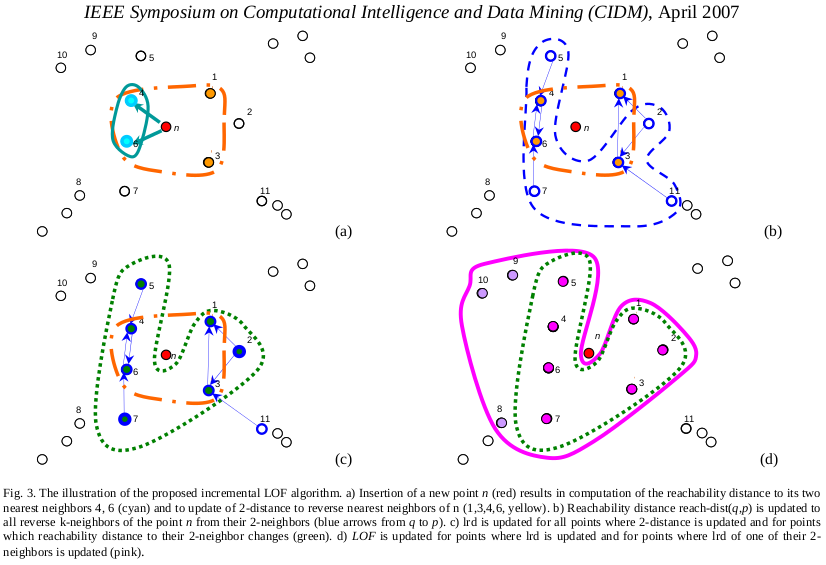

## Generate data with some outliers

We create an artifical data centered around two cluster and add some data made from another distribuition (outliers)

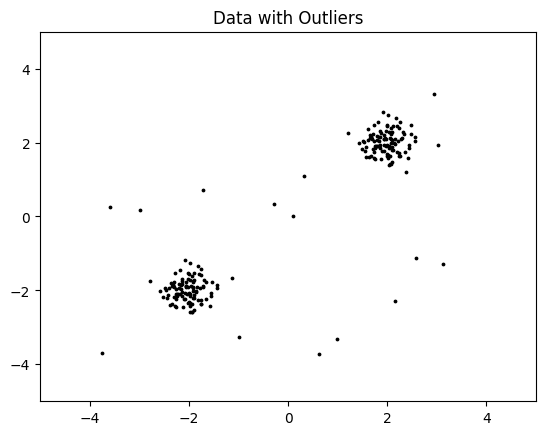

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

#Visualize data
plt.title("Data with Outliers")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

## Online Machine Learning with River

Using the built class ILOF we calculte the Local Outlier Factor in an online approach, at each step we send an instance of data to the model, that will learn it using the 'learn_one' function, updating the model incrementally. 

The class ILOF takes in the following argumetns: 

ILOF(*k_neighbors = int; batch_size = int; verbose = boolean; distance_func = function*)


Function to learn batch of data: 

learn_one(*x: dictionary*)


In [3]:
import ilof_ as ilof
from river import utils

#Convert to dictionary
Xdicts = tuple({f'feature_{i+1}': x[i] for i in range(2)} for x in X)

#Define model
k = 20 #k-neighboors
ilof_river = ilof.ILOF(k, verbose=False)

#Fit model on stream data
for x in Xdicts:
    ilof_river.learn_one(x)

lof_scores_river = np.array([v for v in ilof_river.lof.values()])

We can also evaluate data without adding learning it, this way the programme outputs a LOF for the data but doesn't update the parameters of the model (neighborhoods, reverse neighborhoods, k-distances, reachability-distances, local outlier factor).

The learn_one function can take in the following arguments:
*learn_one(k_neighbors, batch_size, verbose, distance_func)*

In [4]:
#Evaluate data without updating the model
X_score = np.random.uniform(low=-4, high=4, size=(10, 2))

X_score_dict = tuple({f'feature_{i+1}': x[i] for i in range(2)} for x in X_score)

lof_score = []
for x in X_score_dict:
    lof_score.append(ilof_river.score_one(x))

print(lof_score)

[[4.1225951442931335], [4.856989240600968], [6.700737740891463], [4.67398123498832], [10.318743687776967], [1.695085624011412], [3.1578141066216476], [1.6190480666043154], [4.135136784137301], [5.1959975977883746]]


## Batch Machine Learning with Scikit-learn

To compare our results we fit a model with the same data using scikit-learn



In [5]:
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

#Define the model
lof_scikit = LocalOutlierFactor(n_neighbors=k)

#Fit model on data
lof_scikit.fit_predict(X)

#Get Local Outlier Factor
lof_scores_scikit = - lof_scikit.negative_outlier_factor_

## Plot results

We observe that both the online river approach (river) and the batch approach (sklearn) give the same results, but the online has the advantage of being adapted to treat data streams

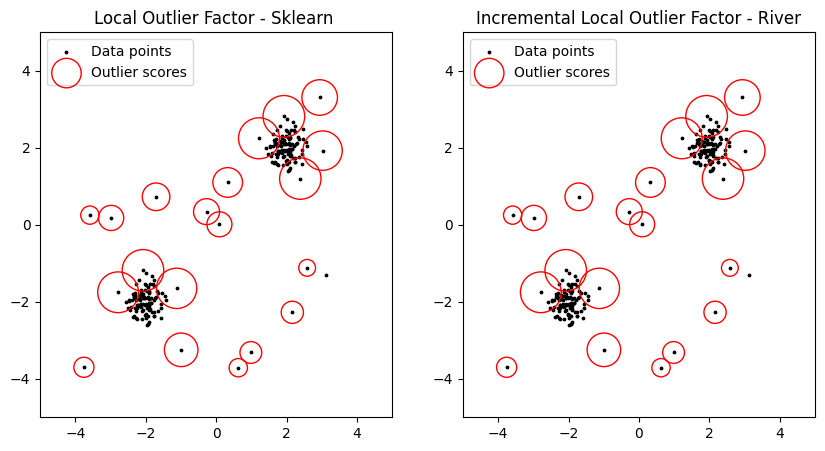

We observe that the difference is at machine error level:


array([-4.09616785e-12, -6.33715302e-11,  1.09381393e-11, -1.17567955e-10,
        1.33887346e-11,  1.18958177e-11, -6.57527366e-11, -7.40709716e-11,
       -7.44937445e-12, -6.17876861e-11, -9.02540265e-11, -2.53728150e-11,
        1.22162280e-11, -1.55155888e-11,  1.49403823e-11, -1.26576083e-10,
       -1.56268332e-11, -4.20663504e-11, -7.77566900e-11, -2.44553267e-11,
       -2.61148880e-11,  1.45454759e-11, -5.68558534e-11, -2.96740410e-11,
       -5.03610487e-11,  6.52056187e-12,  8.45368220e-12, -6.24331697e-11,
        3.10773629e-12, -1.87143634e-11,  1.69848580e-11, -6.51001475e-11,
       -5.37054845e-11, -7.33879624e-12, -4.45921078e-12, -6.28377350e-11,
       -6.90747459e-11, -3.41847439e-10,  1.80840898e-11, -8.69331274e-11,
        2.49876786e-11, -1.05403020e-10, -6.49036380e-12, -5.79656323e-11,
        7.16537940e-12, -7.47046869e-12,  6.71662725e-12, -4.13140633e-11,
       -7.85482790e-13,  1.55593316e-11, -4.18334256e-11,  5.83022519e-12,
        2.18497442e-11, -

In [6]:
from river.utils import dict2numpy
X_scores1 = lof_scores_scikit
X_scores2 = lof_scores_river

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# First plot
radius1 = (X_scores1.max() - X_scores1) / (X_scores1.max() - X_scores1.min()) * (X_scores1 > 1.5)
axs[0].set_title("Local Outlier Factor - Sklearn ")
axs[0].scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
axs[0].axis("tight")
axs[0].set_xlim((-5, 5))
axs[0].set_ylim((-5, 5))
axs[0].scatter(X[:, 0], X[:, 1], s=1000 * radius1, edgecolors="r", facecolors="none", label="Outlier scores")
axs[0].legend(loc="upper left")

# Second plot
radius2 = (max(X_scores2) - X_scores2) / (max(X_scores2) - min(X_scores2)) * (X_scores2 > 1.5)
axs[1].set_title("Incremental Local Outlier Factor - River")
axs[1].scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
axs[1].axis("tight")
axs[1].set_xlim((-5, 5))
axs[1].set_ylim((-5, 5))
axs[1].scatter(X[:, 0], X[:, 1], s=1000 * radius2, edgecolors="r", facecolors="none", label="Outlier scores")
axs[1].legend(loc="upper left")

plt.show()

print('We observe that the difference is at machine error level:')
X_scores1 - X_scores2

## Time comparison

Although not adapted to a batch approach River ILOF also allows to calculate a mini-batch approach using the function 'learn_many', here we compare the time of execution of ScikitLOF and RiverILOF considering both receiving a *batch_size*  number of data points:

ScikitLOF has applies methods like tree search that optimize the search for neighboors so its execution time remains more of less constant

In [7]:
from river import datasets
import pandas as pd
from river.utils import dict2numpy
import time 
dataset = pd.DataFrame(datasets.CreditCard())
dataset_np = [dict2numpy(i) for i in dataset[0].to_dict().values()]

In [8]:
k = 20
batch_sizes = [20,50,100,200,400,1000]

time_river = []
time_scikit = []
for batch_size in batch_sizes:
    #River
    start_time_r = time.time()
    ilof_river2 = ilof.ILOF(k, verbose=False)
    ilof_river2.learn_many(dataset[0:batch_size])
    time_river.append(time.time() - start_time_r)
    ilof_scores_river2 = np.array([v for v in ilof_river2.lof.values()])

    #Scikit
    start_time_s = time.time()
    lof_scikit2 = LocalOutlierFactor(n_neighbors=k)
    lof_scikit2.fit_predict(dataset_np[0:batch_size])
    time_scikit.append(time.time() - start_time_s)
    lof_scores_scikit2 = - lof_scikit2.negative_outlier_factor_

#Compare
print('We observe again that the error is of machine precision level: \
    (the few errors at the scale of e-05 are because of the river minkowski-distance function error, \
    I submitted a correction request, for details see bottom of this document  ')
ilof_scores_river2 - lof_scores_scikit2

We observe again that the error is of machine precision level:     (the few errors at the scale of e-05 are because of the river minkowski-distance function error,     I submitted a correction request, for details see bottom of this document  


array([ 1.15640830e-12,  1.39670502e-05,  1.18705046e-12,  1.55497837e-12,
        4.09583478e-12,  1.33378808e-05,  1.28123493e-05,  1.81729894e-05,
        2.78910228e-12,  1.16189877e-05,  1.14542134e-05,  9.35752947e-03,
        1.18571819e-12,  1.33008174e-05,  2.86748403e-12,  1.16448999e-05,
        1.14404267e-05,  1.10114258e-05,  3.12239123e-12,  1.07421263e-05,
        5.79758463e-13,  1.48459023e-12,  1.02679237e-05,  1.10608636e-05,
        9.62921621e-06,  4.63407090e-13,  1.60071956e-12, -1.26565425e-13,
        1.02962083e-12, -1.02362563e-13, -1.12798659e-13, -8.31557045e-14,
       -1.26343380e-13, -1.26343380e-13, -9.31477118e-14, -9.31477118e-14,
        5.65991698e-13, -1.12909682e-13,  5.81756865e-14, -6.90558721e-14,
        5.17141885e-13, -1.15241150e-13, -3.32289751e-13, -1.55431223e-13,
       -3.33177930e-13, -7.32747196e-14, -1.53210777e-13, -2.20934382e-13,
        5.41122702e-13, -7.88258347e-14, -1.08357767e-13,  3.73034936e-13,
       -1.61870517e-13, -

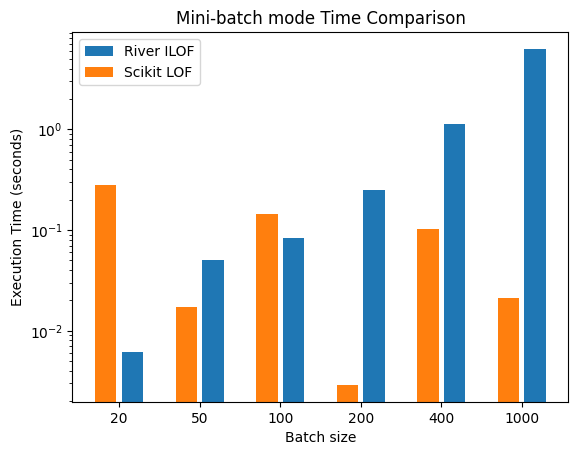

In [9]:
import matplotlib.pyplot as plt
# Plotting the bar graph
plt.bar(np.array(range(len(time_river)))*1.5+0.25, time_river, width=0.4, label='River ILOF')
plt.bar(np.array(range(len(time_river)))*1.5-0.25, time_scikit, width=0.4, label='Scikit LOF')
plt.xticks(np.array(range(len(time_river)))*1.5, batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Execution Time (seconds)')
plt.title('Mini-batch mode Time Comparison')
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
#Time to add new points on existing model with 1000 points
#River
time_r = []
start_t_r = time.time()
for x in dataset[0][1200:1300]:
    ilof_river2.learn_one(x)
time_r.append(time.time() - start_t_r)

#Scikit
time_s = []
start_t_s = time.time()
lof_scikit2.novelty = True
lof_scores_scikit2 = lof_scikit2.score_samples(dataset_np[1200:1300])
time_s.append(time.time() - start_t_s)

print('RiverILOF time:', time_r,';  ScikitLOF time:', time_s, '\n We observe that RiverILOF gets slower as the number of points learned increases,\
since it calculates the distance of the new point to all other ones each iteration.')

RiverILOF time: [5.1155877113342285] ;  ScikitLOF time: [0.22044944763183594] 
 We observe that RiverILOF gets slower as the number of points learned increases,    since it calculates the distance of the new point to all other ones each iteration


In [11]:
#River Minkowski_distance error

import functools
from river import utils
#from river.neighbors.base import DistanceFunc
from river.utils import VectorDict

distancefunc = functools.partial(utils.math.minkowski_distance, p=2)
a={1: 1.5, 2: 3.5}
b={1: -0.7, 2: -10.3}
print(((1.5+0.7)**2+(3.5+10.3)**2)**(1/2), distancefunc(a,b))

13.974262055650739 195.28000000000003
